In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from itertools import cycle, islice

# Загрузка набора данных MNIST
(x, y), _ = mnist.load_data()

# Нормализация значений пикселей от 0 до 1
x = x / 255.0

# Преобразование изображений в одномерные массивы
x = x.reshape((-1, 28 * 28))

# Преобразование меток в one-hot encoding
y_one_hot = np.eye(10)[y]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5 , random_state=42)
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

# Определение архитектуры нейронной сети
def initialize_weights():
    np.random.seed(42)
    weights = {
        'W1': np.random.randn(784, 256) * 0.01,
        'b1': np.zeros((256,)),
        'W2': np.random.randn(256, 128) * 0.01,
        'b2': np.zeros((128,)),
        'W3': np.random.randn(128, 10) * 0.01,
        'b3': np.zeros((10,)),
    }
    return weights

# Функции активации
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Функция предсказания
def predict(weights, x):
    z1 = np.dot(x, weights['W1']) + weights['b1']
    a1 = relu(z1)
    z2 = np.dot(a1, weights['W2']) + weights['b2']
    a2 = relu(z2)
    z3 = np.dot(a2, weights['W3']) + weights['b3']
    a3 = softmax(z3)
    return a3

# Вычисление потерь
def compute_loss(y_true, y_pred):
    loss = -np.mean(np.log(y_pred[np.arange(len(y_true)), y_true.astype(int)]))
    return loss

# Функция вычисления градиентов для каждого веса
def compute_gradients(weights, x, y_true):
    m = x.shape[0]  # Количество примеров в обучающем наборе
    grads = {}  # Словарь для хранения градиентов

    # Прямое распространение (forward pass)
    z1 = np.dot(x, weights['W1']) + weights['b1']
    a1 = relu(z1)
    z2 = np.dot(a1, weights['W2']) + weights['b2']
    a2 = relu(z2)
    z3 = np.dot(a2, weights['W3']) + weights['b3']
    a3 = softmax(z3)

    # Обратное распространение (backward pass)
    dz3 = a3 - y_true
    grads['W3'] = np.dot(a2.T, dz3) / m  # Градиент по весам W3
    grads['b3'] = np.sum(dz3, axis=0) / m  # Градиент по смещениям b3

    da2 = np.dot(dz3, weights['W3'].T)
    dz2 = da2 * (a2 > 0)
    grads['W2'] = np.dot(a1.T, dz2) / m  # Градиент по весам W2
    grads['b2'] = np.sum(dz2, axis=0) / m  # Градиент по смещениям b2

    da1 = np.dot(dz2, weights['W2'].T)
    dz1 = da1 * (a1 > 0)
    grads['W1'] = np.dot(x.T, dz1) / m  # Градиент по весам W1
    grads['b1'] = np.sum(dz1, axis=0) / m  # Градиент по смещениям b1

    return grads  # Возвращаем словарь градиентов для каждого веса

# Функция сортировки весов по их важности (сумма абсолютных значений градиентов)
def sort_weights_by_importance(weights, grads):
    importance = {}  # Словарь для хранения важности каждого веса
    for k in weights.keys():  # Проходим по всем весам
        importance[k] = np.sum(np.abs(grads[k]))  # Вычисляем важность как сумму абсолютных значений градиентов
    # Сортируем веса по их важности в порядке убывания
    sorted_weights = sorted(importance.items(), key=lambda item: item[1], reverse=True)
    return sorted_weights  # Возвращаем список кортежей (вес, важность) в порядке убывания важности

def get_important_weights(weights, grads, threshold=0.8):
    sorted_weights = sort_weights_by_importance(weights, grads)  # Сортировка весов по их важности
    total_importance = sum([item[1] for item in sorted_weights])  # Общая важность всех весов
    accumulated_importance = 0  # Накопленная важность
    important_weights = {}  # Словарь для хранения важных весов
    
    # Проходим по отсортированным весам
    for key, importance in sorted_weights:
        accumulated_importance += importance  # Увеличиваем накопленную важность
        important_weights[key] = weights[key]  # Добавляем вес в словарь важных весов
        # Если накопленная важность превышает пороговое значение, прерываем цикл
        if accumulated_importance / total_importance >= threshold:
            break

    return important_weights  # Возвращаем только важные веса

def compute_log_likelihood(y_true, y_pred):
    likelihood = np.sum(y_true * np.log(y_pred + 1e-9))  # Добавление маленького значения для стабильности
    return likelihood  # Нормализация на количество образцов

def metropolis_hastings(weights, x_train, y_train, x_test, y_test, sigma_origin, sigma_delta, n_iter=100, burn_in=0, batch_size=64, important_after_iter=100):
    current_pred = predict(weights, x_train)
    current_likelihood = compute_log_likelihood(y_train_one_hot, current_pred)
    best_likelihood = current_likelihood
    best_weights = {k: v.copy() for k, v in weights.items()}
    sigmas = {k: np.full(v.shape, sigma_origin).astype(np.float32) for k, v in weights.items()}
    accepted = 0
    test_accs = []
    sigma_means = []
    samples = []
    
    important_weights = None

    for i in tqdm(range(n_iter)):
        if i == important_after_iter:
            grads = compute_gradients(weights, x_train, y_train_one_hot)
            important_weights = get_important_weights(weights, grads)

        if i < important_after_iter:
            # Первые important_after_iter итераций обновляем все веса
            new_weights = {k: (v + np.random.normal(0, sigma, v.shape)) for (k, v), sigma in zip(weights.items(), sigmas.values())}
        else:
            # После important_after_iter итераций обновляем только важные веса
            new_weights = {k: (v + np.random.normal(0, sigma, v.shape) if k in important_weights else v)
                           for (k, v), sigma in zip(weights.items(), sigmas.values())}

        new_pred = predict(new_weights, x_train)
        new_likelihood = compute_log_likelihood(y_train_one_hot, new_pred)

        accept_prob = np.min([1, np.exp(new_likelihood - current_likelihood)])
        if np.random.uniform() < accept_prob:
            current_likelihood = new_likelihood
            accepted += 1  
            weights = new_weights
            if new_likelihood > best_likelihood:
                best_likelihood = new_likelihood
                best_weights = {k: v.copy() for k, v in new_weights.items()}
        else:
            weights = best_weights

        if i >= burn_in:
            test_pred = predict(weights, x_test)
            test_loss = compute_loss(y_test, test_pred)
            test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)
            test_accs.append(test_acc)
            train_pred = predict(weights, x_train)
            train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)
            
            sigma_mean = np.mean([np.mean(np.abs(s)) for s in sigmas.values()])
            sigma_means.append(sigma_mean)

            sample = {}
            
            # Выборка только 3-х весов
            sample = {f'{k}_{idx}': val for k, v in weights.items() for idx, val in islice(np.ndenumerate(v), 3)}
            
            sample['likelihood'] = np.exp(current_likelihood / y_train_one_hot.shape[0])
            sample['test_acc'] = test_acc
            sample['train_acc'] = train_acc
            samples.append(sample)

        sigmas = {k: np.maximum(0.001, sigma + np.random.normal(0, sigma_delta, sigma.shape)) for k, sigma in sigmas.items()}

    accept_rate = accepted / n_iter

    # таблица семплов
    samples_df = pd.DataFrame(samples)

    return best_weights, sigma_means, test_accs, accept_rate, samples_df, important_weights

def evaluate_model(weights, sigma_means, test_accs, accept_rate, x_train, y_train, x_test, y_test, samples_df, important_weights):
    test_pred = predict(weights, x_test)
    test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)
    test_f1 = f1_score(y_test, np.argmax(test_pred, axis=1), average='weighted')

    train_pred = predict(weights, x_train)
    train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)
    train_f1 = f1_score(y_train, np.argmax(train_pred, axis=1), average='weighted')

    print(f'Точность на тестовых данных: {test_acc * 100:.2f}%')
    print(f'F1-метрика на тестовых данных: {test_f1:.2f}')
    print(f'Коэффициент принятия: {accept_rate * 100:.2f}%')
    print(f'Точность на обучающих данных: {train_acc * 100:.2f}%')
    print(f'F1-метрика на обучающих данных: {train_f1:.2f}')

    total_params = sum(v.size for v in weights.values())
    if important_weights is not None:
        important_params = sum(v.size for v in important_weights.values())
        percent_important_weights = (important_params / total_params) * 100
        print(f'Общее количество параметров: {total_params}')
        print(f'Количество важных параметров: {important_params}')
        print(f'Процент важных параметров: {percent_important_weights:.2f}%')
    else:
        print("Нет важных весов, так как порог важности не достигнут.")

    max_acc_index = np.argmax(test_accs)
    sigma_mean_at_max_acc = sigma_means[max_acc_index]
    print(f'Среднее значение сигмы при максимальной точности на тестовых данных: {sigma_mean_at_max_acc}')
    
    plt.figure()
    plt.plot(sigma_means, test_accs)
    plt.xlabel('Среднее значение стандартных отклонений')
    plt.ylabel('Точность предсказаний на тестовой выборке')
    plt.title('Точность предсказаний на тестовой выборке от среднего значения стандартных отклонений')
    plt.savefig('MLP_100k_FINAL_Точность предсказаний на тестовой выборке от среднего значения стандартных отклонений.png')
    plt.show()

    # ROC-кривая и AUC для тестовых данных
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], test_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(10), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Частота ложных срабатываний')
    plt.ylabel('Частота истинных срабатываний')
    plt.title('ROC-кривая для мультиклассовой классификации')
    plt.legend(loc='lower right')
    plt.savefig('MLP_100k_FINAL_ROC-кривая для мультиклассовой классификации.png')
    plt.show()

    plt.figure()
    plt.plot(np.exp(samples_df['likelihood']))
    plt.xlabel('Итерации')
    plt.ylabel('Значения функции правдоподобия')
    plt.title('Динамика значений функции правдоподобия от числа итераций')
    plt.savefig('MLP_100k_FINAL_Динамика значений функции правдоподобия от числа итераций.png')
    plt.show()

    plt.figure()
    plt.scatter(np.exp(samples_df['likelihood']), samples_df['train_acc'])
    plt.xlabel('Значения функции правдоподобия')
    plt.ylabel('Точность предсказаний на обучающей выборке')
    plt.title('Значения точности предсказаний на обучающей от значений функции правдоподобия')
    plt.savefig('MLP_100k_FINAL_Значения точности предсказаний на обучающей от значений функции правдоподобия.png')
    plt.show()

    #Изменение правдоподобия и точности на тренировочных данных
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(samples_df['likelihood'], color='b', label='Правдоподобие')
    ax1.set_xlabel('Итерации')
    ax1.set_ylabel('Правдоподобие', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax2 = ax1.twinx()  
    ax2.plot(samples_df['train_acc'], color='r', label='Точность на тренировочных данных')
    ax2.plot(samples_df['test_acc'], color='g', label='Точность на тестовых данных')
    ax2.set_ylabel('Точность', color='black')  
    ax2.tick_params(axis='y', labelcolor='black')
    fig.suptitle('Динамика значений функции правдоподобия и точностей на обучающих и тестовых выборках от числа итераций')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    plt.show()
    plt.savefig('MLP_100k_FINAL_Динамика значений функции правдоподобия и точностей на обучающих и тестовых выборках от числа итераций.png')
    plt.show()

    #Изменение логарифмированного правдоподобия и точности на тестовых и тренировочных данных
    fig2, ax4 = plt.subplots(figsize=(10, 6))
    # Первый график - логарифмированное правдоподобие и точность на тренировочных данных
    ax4.scatter(np.log(samples_df['likelihood']), samples_df['train_acc'], s=1, label='Точность на тренировочных данных', color='b')
    ax4.set_xlabel('Логарифмированное правдоподобие')
    ax4.set_ylabel('Точность на тренировочных данных', color='b')
    ax4.tick_params(axis='y', labelcolor='b')
    # Второй график - логарифмированное правдоподобие и точность на тестовых данных
    ax5 = ax4.twinx()  
    ax5.scatter(np.log(samples_df['likelihood']), samples_df['test_acc'], s=1, label='Точность на тестовых данных', color='g')
    ax5.set_ylabel('Точность на тестовых данных', color='g')  
    ax5.tick_params(axis='y', labelcolor='g')  
    # Заголовок
    fig2.suptitle('Изменение точности предсказаний на тестовых и обучающих выборках от логарифмического правдоподобия')
    # Объединенная легенда
    lines, labels = ax4.get_legend_handles_labels()
    lines2, labels2 = ax5.get_legend_handles_labels()
    ax4.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    plt.savefig('MLP_100k_FINAL_Изменение точности предсказаний на тестовых и обучающих выборках от логарифмического правдоподобия.png')
    plt.show()
    
    # Вывод таблицы семплов
    print("Таблица семплов весов:")
    print(samples_df)

weights = initialize_weights()

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [16:12:46<00:00,  1.71it/s]


Точность на тестовых данных: 95.02%
F1-метрика на тестовых данных: 0.95
Коэффициент принятия: 26.17%
Точность на обучающих данных: 96.92%
F1-метрика на обучающих данных: 0.97
Общее количество параметров: 235146
Количество важных параметров: 233472
Процент важных параметров: 99.29%
Среднее значение сигмы при максимальной точности на тестовых данных: 0.0034288409103072916


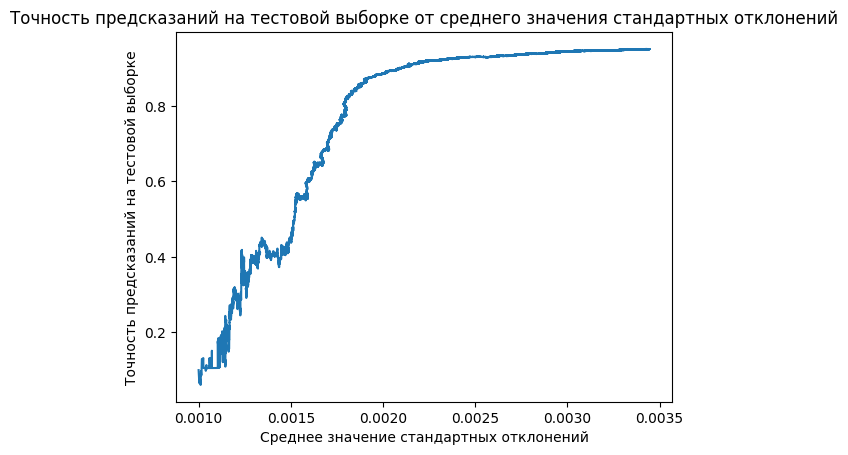

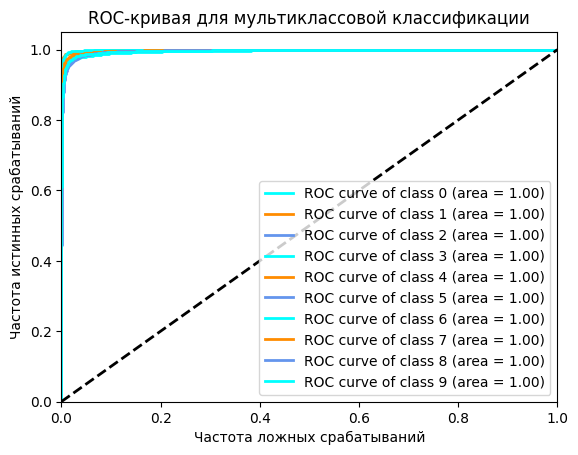

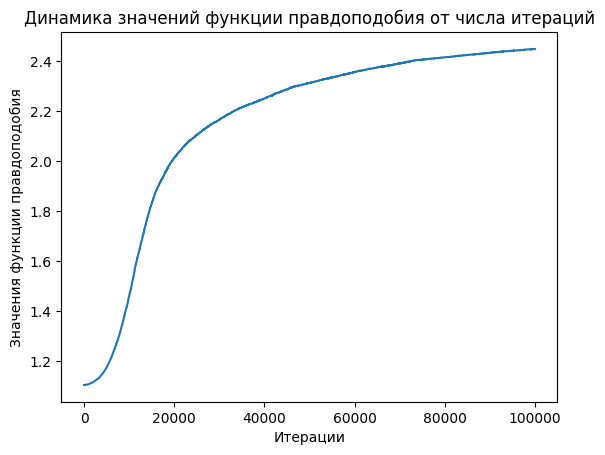

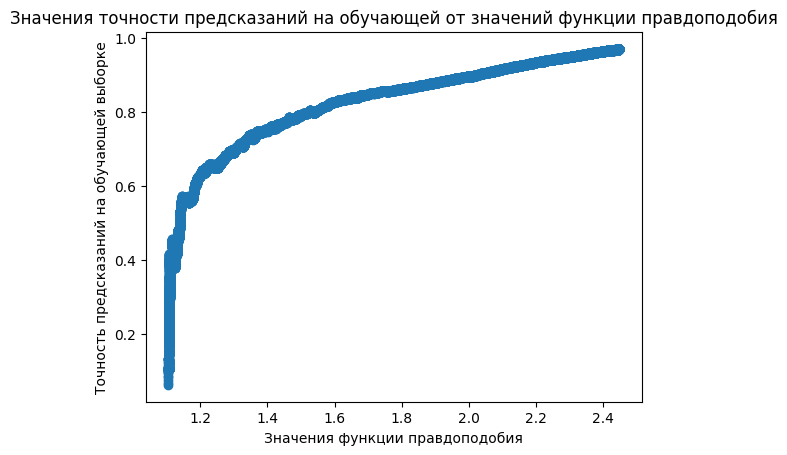

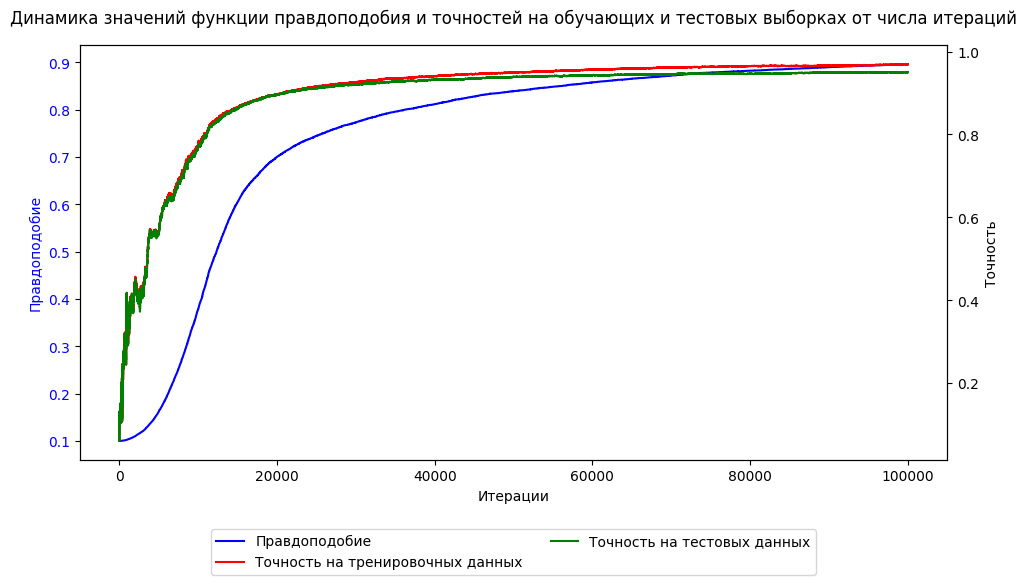

<Figure size 640x480 with 0 Axes>

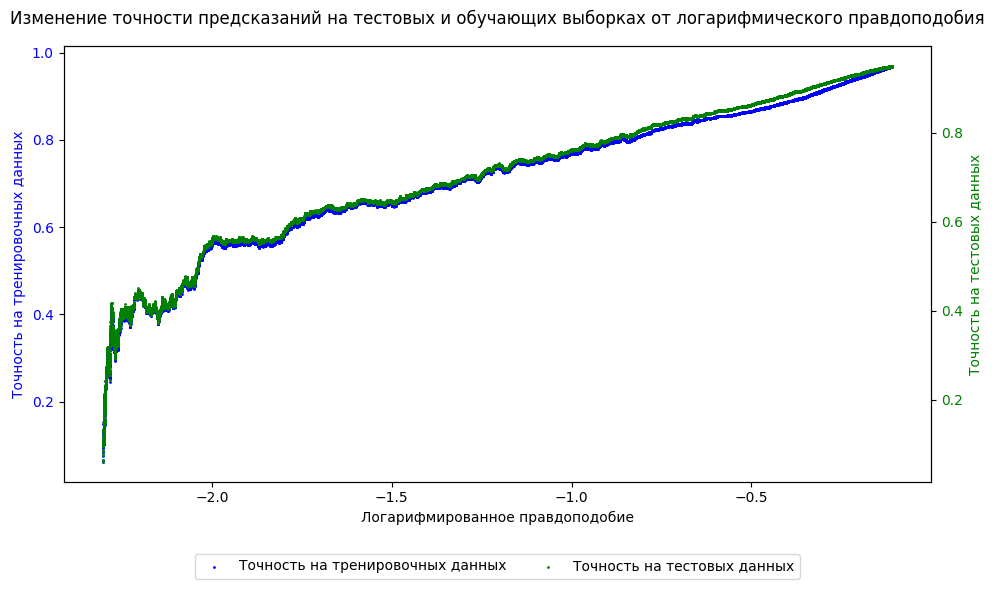

Таблица семплов весов:
       W1_(0, 0)  W1_(0, 1)  W1_(0, 2)   b1_(0,)   b1_(1,)   b1_(2,)  \
0       0.004967  -0.001383   0.006477  0.000000  0.000000  0.000000   
1       0.005187  -0.001469   0.005495  0.002715 -0.000200  0.000180   
2       0.005448  -0.000963   0.006238  0.003801  0.000158  0.000885   
3       0.006044  -0.002057   0.006285  0.002488  0.001355  0.002215   
4       0.006091  -0.001827   0.006731  0.001771  0.001407  0.003353   
...          ...        ...        ...       ...       ...       ...   
99995  -0.158976   0.056788  -0.098294 -0.028378 -0.056952  0.048376   
99996  -0.159844   0.056202  -0.099837 -0.028378 -0.056952  0.048376   
99997  -0.157025   0.049571  -0.100660 -0.028378 -0.056952  0.048376   
99998  -0.159844   0.056202  -0.099837 -0.028378 -0.056952  0.048376   
99999  -0.159844   0.056202  -0.099837 -0.028378 -0.056952  0.048376   

       W2_(0, 0)  W2_(0, 1)  W2_(0, 2)   b2_(0,)  ...   b2_(2,)  W3_(0, 0)  \
0      -0.004487   0.000171  -0.01

In [12]:
best_weights, sigma_means, test_accs, accept_rate, samples_df, important_weights  = metropolis_hastings(weights, x_train, y_train, x_test, y_test,
        sigma_origin = 0.001, sigma_delta = 0.00001, n_iter=100000 , burn_in=0, important_after_iter=1000)
samples_df.to_csv('MLP_100k_FINAL_samples.csv', index=False)
evaluate_model(best_weights, sigma_means, test_accs, accept_rate, x_train, y_train, x_test, y_test, samples_df, important_weights)

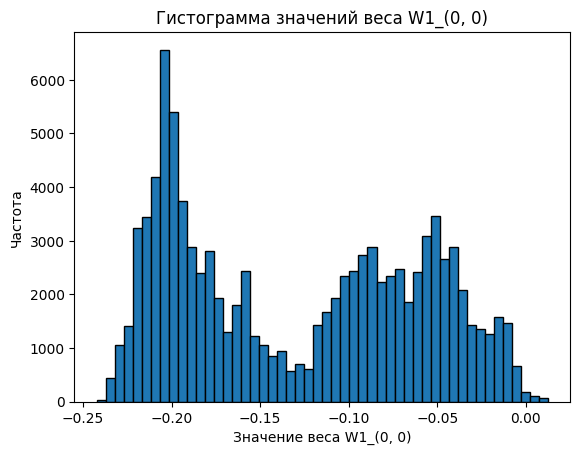

In [36]:
W1_00_values = samples_df['W1_(0, 0)']
plt.hist(W1_00_values, bins=50, edgecolor='black')
plt.title('Гистограмма значений веса W1_(0, 0)')
plt.xlabel('Значение веса W1_(0, 0)')
plt.ylabel('Частота')
plt.savefig('MLP_100k_FINAL_Гистограмма значений веса W1_(0, 0).png')
plt.show()

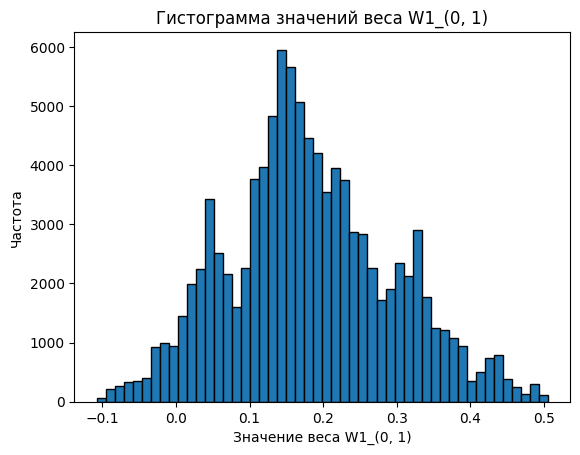

In [37]:
W1_01_values = samples_df['W1_(0, 1)']
plt.hist(W1_01_values, bins=50, edgecolor='black')
plt.title('Гистограмма значений веса W1_(0, 1)')
plt.xlabel('Значение веса W1_(0, 1)')
plt.ylabel('Частота')
plt.savefig('MLP_100k_FINAL_Гистограмма значений веса W1_(0, 1).png')
plt.show()

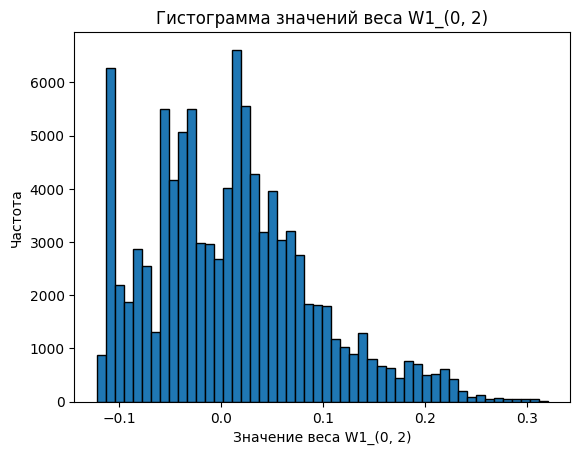

In [38]:
W1_02_values = samples_df['W1_(0, 2)']
plt.hist(W1_02_values, bins=50, edgecolor='black')
plt.title('Гистограмма значений веса W1_(0, 2)')
plt.xlabel('Значение веса W1_(0, 2)')
plt.ylabel('Частота')
plt.savefig('MLP_100k_FINAL_Гистограмма значений веса W1_(0, 2).png')
plt.show()

In [39]:
def evaluate_model(weights, sigma_means, test_accs, accept_rate, x_train, y_train, x_test, y_test, samples_df, important_weights):
    test_pred = predict(weights, x_test)
    test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)
    test_f1 = f1_score(y_test, np.argmax(test_pred, axis=1), average='weighted')

    train_pred = predict(weights, x_train)
    train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)
    train_f1 = f1_score(y_train, np.argmax(train_pred, axis=1), average='weighted')

    print(f'Точность на тестовых данных: {test_acc * 100:.2f}%')
    print(f'F1-метрика на тестовых данных: {test_f1:.2f}')
    print(f'Коэффициент принятия: {accept_rate * 100:.2f}%')
    print(f'Точность на обучающих данных: {train_acc * 100:.2f}%')
    print(f'F1-метрика на обучающих данных: {train_f1:.2f}')

    total_params = sum(v.size for v in weights.values())
    if important_weights is not None:
        important_params = sum(v.size for v in important_weights.values())
        percent_important_weights = (important_params / total_params) * 100
        print(f'Общее количество параметров: {total_params}')
        print(f'Количество важных параметров: {important_params}')
        print(f'Процент важных параметров: {percent_important_weights:.2f}%')
    else:
        print("Нет важных весов, так как порог важности не достигнут.")

    max_acc_index = np.argmax(test_accs)
    sigma_mean_at_max_acc = sigma_means[max_acc_index]
    print(f'Среднее значение сигмы при максимальной точности на тестовых данных: {sigma_mean_at_max_acc}')
    
    plt.figure()
    plt.plot(sigma_means, test_accs)
    plt.xlabel('Среднее значение стандартных отклонений')
    plt.ylabel('Точность предсказаний на тестовой выборке')
    plt.title('Точность предсказаний на тестовой выборке от среднего значения стандартных отклонений')
    plt.savefig('MLP_100k_FINAL_Точность предсказаний на тестовой выборке от среднего значения стандартных отклонений.png')
    plt.show()

    # ROC-кривая и AUC для тестовых данных
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], test_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'black', 'pink', 'brown'])
    for i, color in zip(range(10), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Частота ложных срабатываний')
    plt.ylabel('Частота истинных срабатываний')
    plt.title('ROC-кривая для мультиклассовой классификации')
    plt.legend(loc='lower right')
    plt.savefig('MLP_100k_FINAL_ROC-кривая для мультиклассовой классификации.png')
    plt.show()

    plt.figure()
    plt.plot(np.exp(samples_df['likelihood']))
    plt.xlabel('Итерации')
    plt.ylabel('Значения функции правдоподобия')
    plt.title('Динамика значений функции правдоподобия от числа итераций')
    plt.savefig('MLP_100k_FINAL_Динамика значений функции правдоподобия от числа итераций.png')
    plt.show()

    plt.figure()
    plt.scatter(np.exp(samples_df['likelihood']), samples_df['train_acc'])
    plt.xlabel('Значения функции правдоподобия')
    plt.ylabel('Точность предсказаний на обучающей выборке')
    plt.title('Значения точности предсказаний на обучающей от значений функции правдоподобия')
    plt.savefig('MLP_100k_FINAL_Значения точности предсказаний на обучающей от значений функции правдоподобия.png')
    plt.show()

    #Изменение правдоподобия и точности на тренировочных данных
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(samples_df['likelihood'], color='b', label='Правдоподобие')
    ax1.set_xlabel('Итерации')
    ax1.set_ylabel('Правдоподобие', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax2 = ax1.twinx()  
    ax2.plot(samples_df['train_acc'], color='r', label='Точность на тренировочных данных')
    ax2.plot(samples_df['test_acc'], color='g', label='Точность на тестовых данных')
    ax2.set_ylabel('Точность', color='black')  
    ax2.tick_params(axis='y', labelcolor='black')
    fig.suptitle('Динамика значений функции правдоподобия и точностей на обучающих и тестовых выборках от числа итераций')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    plt.show()
    plt.savefig('MLP_100k_FINAL_Динамика значений функции правдоподобия и точностей на обучающих и тестовых выборках от числа итераций.png')
    plt.show()

    #Изменение логарифмированного правдоподобия и точности на тестовых и тренировочных данных
    fig2, ax4 = plt.subplots(figsize=(10, 6))
    # Первый график - логарифмированное правдоподобие и точность на тренировочных данных
    ax4.scatter(np.log(samples_df['likelihood']), samples_df['train_acc'], s=1, label='Точность на тренировочных данных', color='b')
    ax4.set_xlabel('Логарифмированное правдоподобие')
    ax4.set_ylabel('Точность на тренировочных данных', color='b')
    ax4.tick_params(axis='y', labelcolor='b')
    # Второй график - логарифмированное правдоподобие и точность на тестовых данных
    ax5 = ax4.twinx()  
    ax5.scatter(np.log(samples_df['likelihood']), samples_df['test_acc'], s=1, label='Точность на тестовых данных', color='g')
    ax5.set_ylabel('Точность на тестовых данных', color='g')  
    ax5.tick_params(axis='y', labelcolor='g')  
    # Заголовок
    fig2.suptitle('Изменение точности предсказаний на тестовых и обучающих выборках от логарифмического правдоподобия')
    # Объединенная легенда
    lines, labels = ax4.get_legend_handles_labels()
    lines2, labels2 = ax5.get_legend_handles_labels()
    ax4.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    plt.savefig('MLP_100k_FINAL_Изменение точности предсказаний на тестовых и обучающих выборках от логарифмического правдоподобия.png')
    plt.show()
    
    # Вывод таблицы семплов
    print("Таблица семплов весов:")
    print(samples_df)

Точность на тестовых данных: 95.02%
F1-метрика на тестовых данных: 0.95
Коэффициент принятия: 26.17%
Точность на обучающих данных: 96.92%
F1-метрика на обучающих данных: 0.97
Общее количество параметров: 235146
Количество важных параметров: 233472
Процент важных параметров: 99.29%
Среднее значение сигмы при максимальной точности на тестовых данных: 0.0034288409103072916


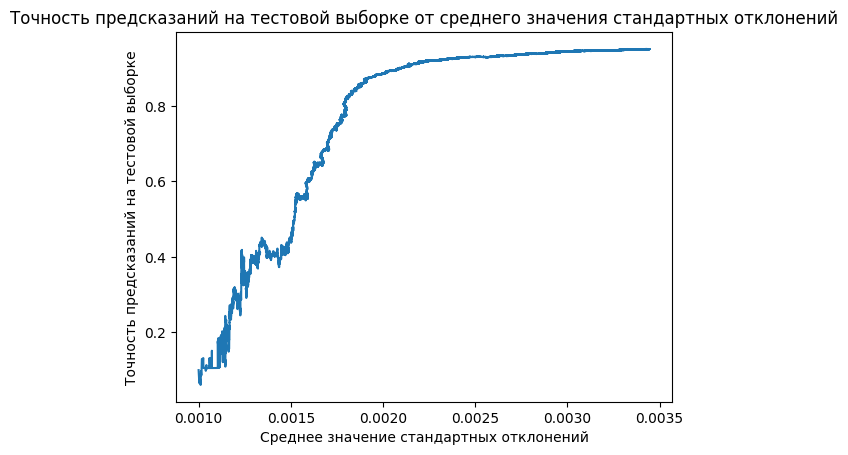

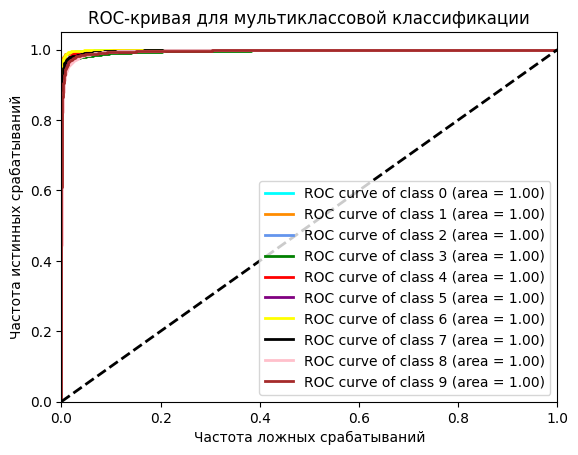

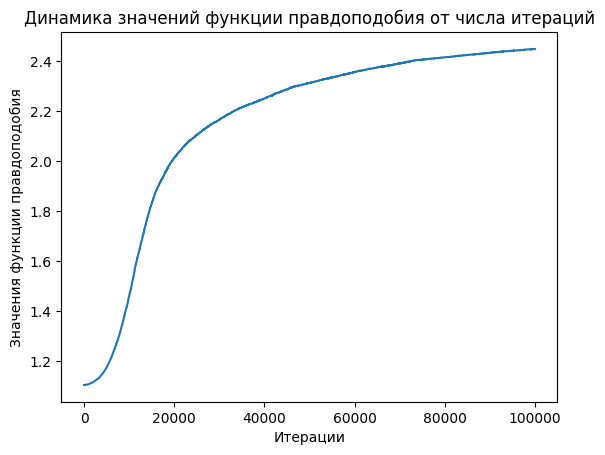

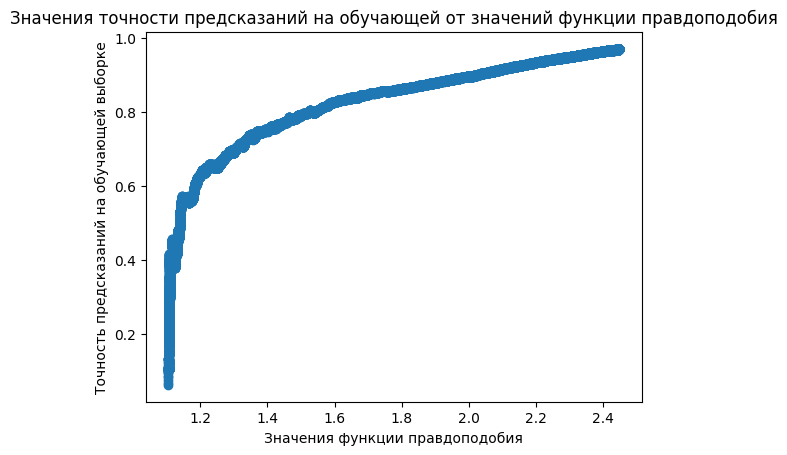

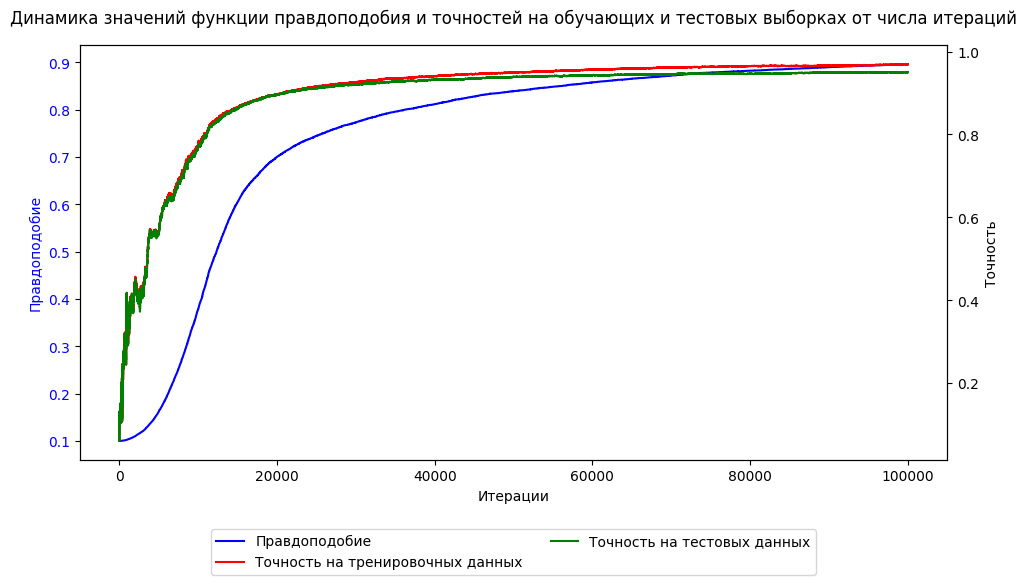

<Figure size 640x480 with 0 Axes>

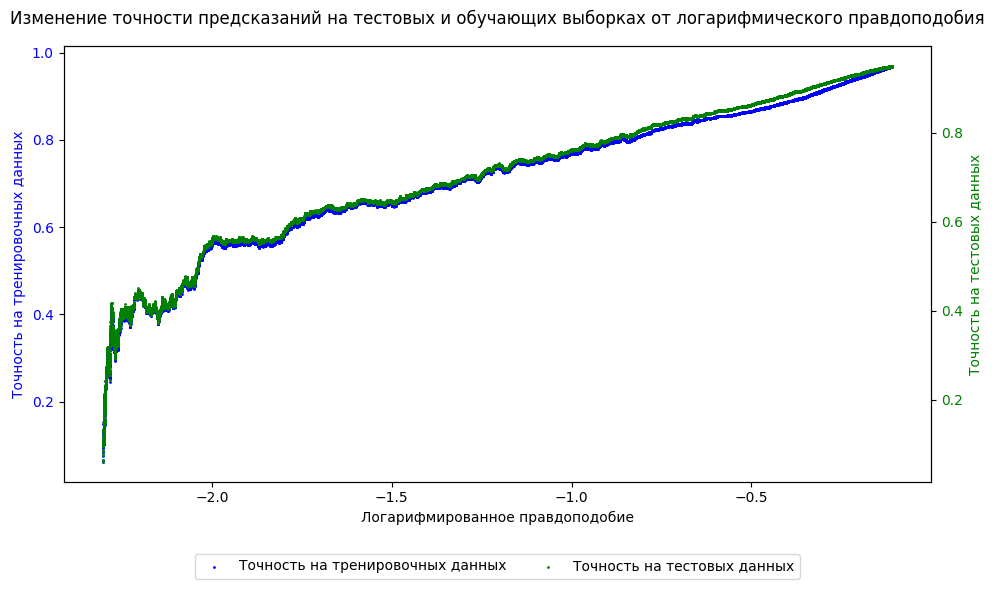

Таблица семплов весов:
       W1_(0, 0)  W1_(0, 1)  W1_(0, 2)   b1_(0,)   b1_(1,)   b1_(2,)  \
0       0.004967  -0.001383   0.006477  0.000000  0.000000  0.000000   
1       0.005187  -0.001469   0.005495  0.002715 -0.000200  0.000180   
2       0.005448  -0.000963   0.006238  0.003801  0.000158  0.000885   
3       0.006044  -0.002057   0.006285  0.002488  0.001355  0.002215   
4       0.006091  -0.001827   0.006731  0.001771  0.001407  0.003353   
...          ...        ...        ...       ...       ...       ...   
99995  -0.158976   0.056788  -0.098294 -0.028378 -0.056952  0.048376   
99996  -0.159844   0.056202  -0.099837 -0.028378 -0.056952  0.048376   
99997  -0.157025   0.049571  -0.100660 -0.028378 -0.056952  0.048376   
99998  -0.159844   0.056202  -0.099837 -0.028378 -0.056952  0.048376   
99999  -0.159844   0.056202  -0.099837 -0.028378 -0.056952  0.048376   

       W2_(0, 0)  W2_(0, 1)  W2_(0, 2)   b2_(0,)  ...   b2_(2,)  W3_(0, 0)  \
0      -0.004487   0.000171  -0.01

In [40]:
evaluate_model(best_weights, sigma_means, test_accs, accept_rate, x_train, y_train, x_test, y_test, samples_df, important_weights)